In [1]:
import rasterio
from rasterio import plot
from rasterio.transform import Affine
from rasterio.features import sieve
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
src_1 = rasterio.open('../landsat/LC08_L1TP_005070_20190806_20190820_01_T1_B4.TIF')

In [3]:
src_1.name

'../landsat/LC08_L1TP_005070_20190806_20190820_01_T1_B4.TIF'

In [4]:
src_1.mode

'r'

In [5]:
src_1.closed

False

In [6]:
src_1.count

1

In [7]:
src_1.width

7651

In [9]:
src_1.height

7771

In [10]:
src_1.dtypes

('uint16',)

In [11]:
{i: dtype for i, dtype in zip(src_1.indexes, src_1.dtypes)}

{1: 'uint16'}

## Georreferenciación de conjuntos de datos 

In [12]:
src_1.bounds

BoundingBox(left=507585.0, bottom=-1715415.0, right=737115.0, top=-1482285.0)

In [13]:
src_1.transform

Affine(30.0, 0.0, 507585.0,
       0.0, -30.0, -1482285.0)

In [14]:
src_1.transform * (0, 0)

(507585.0, -1482285.0)

In [16]:
src_1.transform * (src_1.width, src_1.height)

(737115.0, -1715415.0)

In [17]:
src_1.crs

CRS.from_epsg(32618)

## Lectura de datos ráster

In [18]:
src_1.indexes

(1,)

In [19]:
band4_1 = src_1.read(1)

In [20]:
band4_1

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

In [21]:
band4_1[src_1.height // 2, src_1.width // 2]

10767

## Indexación espacial

In [22]:
#  Para obtener el valor del píxel 100 kilómetros al este y 
#  50 kilómetros al sur de la esquina superior izquierda del conjunto de datos
x, y = (src_1.bounds.left + 100000, src_1.bounds.top - 50000) 

In [23]:
row, col = src_1.index(x, y)
row, col

(1666, 3333)

In [24]:
band4_1[row, col]

7361

In [25]:
src_1.xy(src_1.height // 2, src_1.width // 2)

(622350.0, -1598850.0)

## Creando datos

In [26]:
x = np.linspace(-4.0, 4.0, 240) 
y = np.linspace(-3.0, 3.0, 180)
X, Y = np.meshgrid(x, y)
Z1 = np.exp(-2 * np.log(2) * ((X - 0.5) ** 2 + (Y - 0.5) ** 2) / 1 ** 2)
Z2 = np.exp(-3 * np.log(2) * ((X + 0.5) ** 2 + (Y + 0.5) ** 2) / 2.5 ** 2)
Z = 10.0 * (Z2 - Z1)

### Abrir un conjunto de datos en modo de escritura

Para guardar esta matriz junto con la información de georreferenciación en un nuevo archivo de datos ráster, llame rasterio.open()con una ruta al nuevo archivo que se creará, 'w'para especificar el modo de escritura y varios argumentos de palabras clave.

    driver : el nombre del controlador de formato deseado
    ancho : el número de columnas del conjunto de datos
    altura : el número de filas del conjunto de datos
    cuenta : una cuenta de las bandas del conjunto de datos
    dtype : el tipo de datos del conjunto de datos
    crs : un identificador o descripción del sistema de referencia de coordenadas
    transform : una matriz de transformación afín, y
    nodata : un valor "nodata"
    
En este ejemplo, el sistema de referencia de coordenadas será '+proj=latlong', que describe un sistema de referencia de coordenadas equirectangulares con unidades de grados decimales. La matriz de transformación afín adecuada se puede calcular a partir del producto de matriz de una traducción y una escala.

In [27]:
res = (x[-1] - x[0]) / 240.0
transform = Affine.translation(x[0] - res / 2, y[0] - res / 2) * Affine.scale(res, res)
transform

Affine(0.03333333333333333, 0.0, -4.016666666666667,
       0.0, 0.03333333333333333, -3.0166666666666666)

El punto superior izquierdo en la cuadrícula de ejemplo está a 3 grados oeste y 2 grados norte. El píxel de trama centrado en este punto de la cuadrícula se extiende , o 1/60 grados, en cada dirección, de ahí el cambio en la expresión anterior.res / 2

In [28]:
new_src = rasterio.open(
     '../new.tif',
     'w',
     driver='GTiff',
     height=Z.shape[0],
     width=Z.shape[1],
     count=1,
     dtype=Z.dtype,
     crs='+proj=latlong',
     transform=transform,
     )

### Guardando datos ráster

In [29]:
new_src.write(Z, 1)
new_src.close()

Text(0.5, 1.0, 'Simplest default with labels')

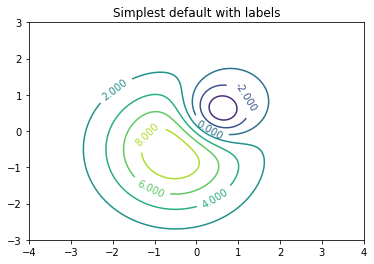

In [30]:
fig, ax = plt.subplots()
CS = ax.contour(X, Y, Z)
ax.clabel(CS, inline=1, fontsize=10)
ax.set_title('Simplest default with labels')

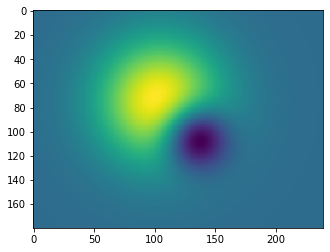

In [31]:
src_2 = rasterio.open('../new.tif')
band_2 = src_2.read(1)

plot.show(band_2)

In [32]:
src_3 = rasterio.open("tests/data/RGB.byte.tif")

In [33]:
src_3.colorinterp

(<ColorInterp.red: 3>, <ColorInterp.green: 4>, <ColorInterp.blue: 5>)

In [34]:
src_1.colorinterp

(<ColorInterp.gray: 1>,)

In [35]:
src_3.count

3

In [36]:
src_3.profile

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 791, 'height': 718, 'count': 3, 'crs': CRS.from_epsg(32618), 'transform': Affine(300.0379266750948, 0.0, 101985.0,
       0.0, -300.041782729805, 2826915.0), 'tiled': False, 'interleave': 'pixel'}

In [37]:
profile = src_3.profile
profile['photometric'] = "RGB"
with rasterio.open("../rgb.tif", 'w', **profile) as dst:
    dst.write(src_3.read())

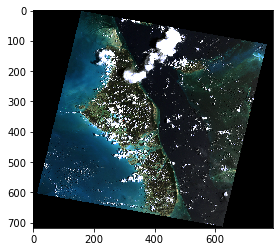

In [38]:
src_4 = rasterio.open('../rgb.tif')
band_4 = src_4.read()
plot.show(band_4)

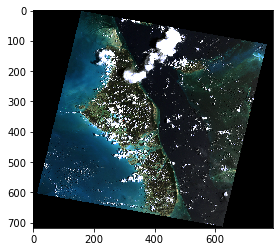

In [40]:
image = plot.reshape_as_image(band_4)
plt.imshow(image)
plt.show()

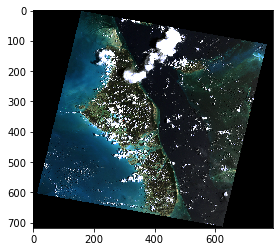

In [41]:
raster = plot.reshape_as_raster(image)
plot.show(raster)

(718, 791)


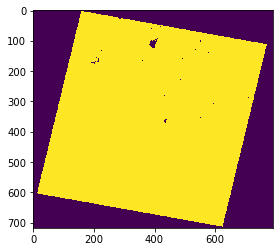

In [42]:
mask = band_4[0] == 0
print(mask.shape)
#plt.imshow(~mask)
#plt.show()
plot.show(~mask*255)

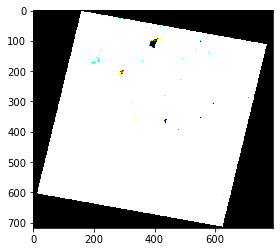

In [43]:
mask = band_4 == 0
mask2 = ~mask*255
plot.show(mask2)

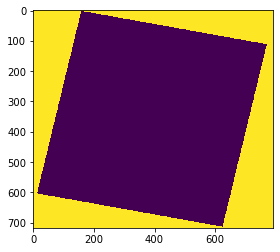

In [44]:
new_msk = np.array((mask[0] & mask[1] & mask[2]), dtype='int16')
sieved_msk = sieve(new_msk, size=800)
plot.show(sieved_msk)

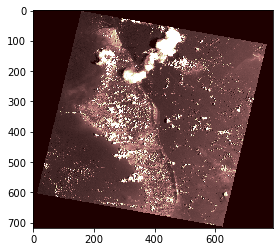

In [45]:
plt.imshow(band_4[0], cmap='pink')
plt.show()

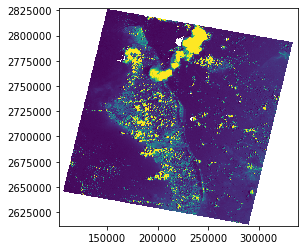

In [46]:
plot.show(src_4)

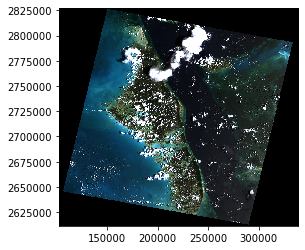

In [47]:
plot.show(src_4.read(), transform=src_4.transform)

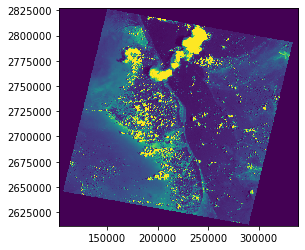

In [48]:
plot.show((src_4, 2), cmap='viridis')

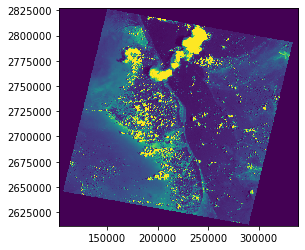

In [49]:
plot.show(src_4.read(2), transform=src_4.transform, cmap='viridis')

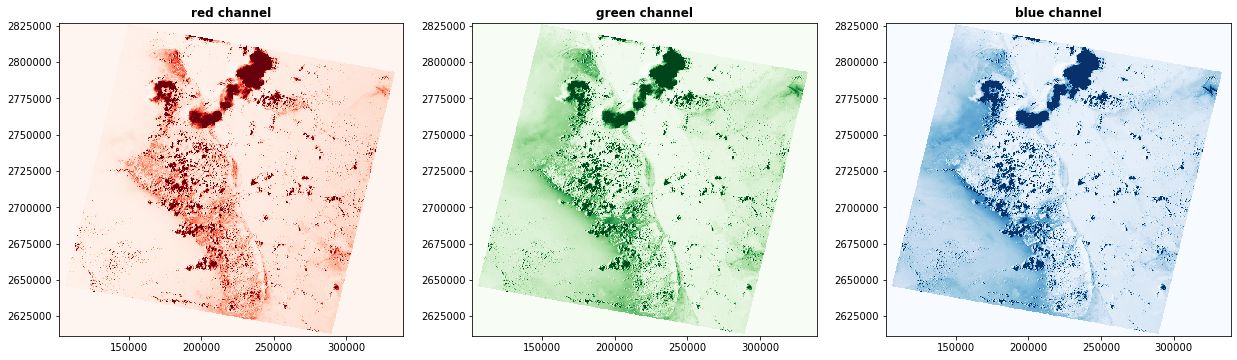

In [58]:
fig, (axr, axg, axb) = plt.subplots(1, 3, figsize=(21, 7))
plot.show((src_4, 1), ax=axr, cmap='Reds', title='red channel')
plot.show((src_4, 2), ax=axg, cmap='Greens', title='green channel')
plot.show((src_4, 3), ax=axb, cmap='Blues', title='blue channel')
plt.show()

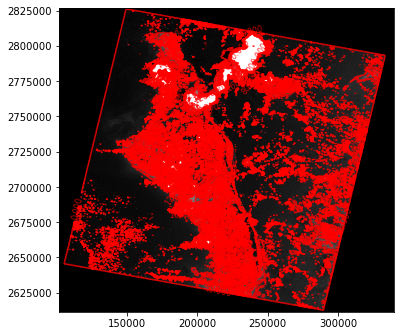

In [62]:
fig, ax = plt.subplots(1, figsize=(6, 6))
plot.show((src_4, 1), cmap='Greys_r', interpolation='none', ax=ax)
plot.show((src_4, 1), contour=True, ax=ax)
plt.show()

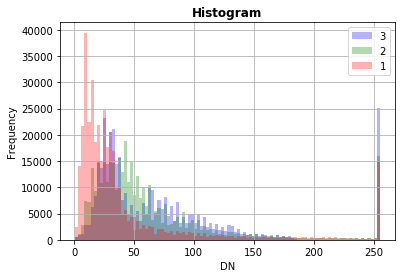

In [67]:
plot.show_hist(src_4, bins=100, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title='Histogram')

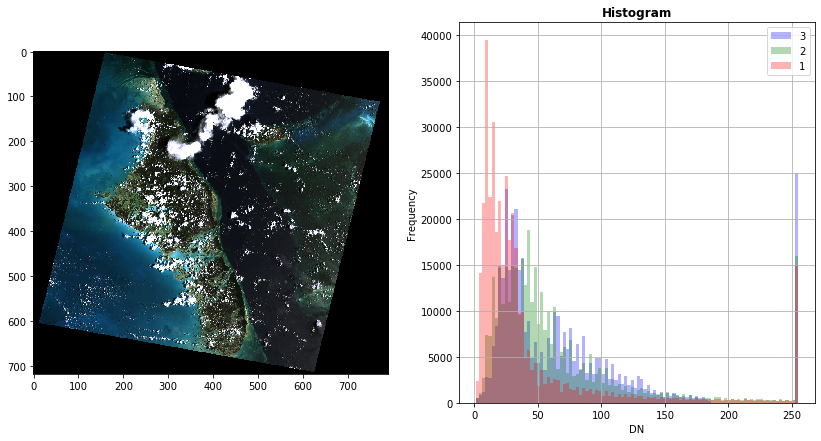

In [69]:
fig, (axrgb, axhist) = plt.subplots(1, 2, figsize=(14, 7))
plot.show(src_4.read(), ax=axrgb)
plot.show_hist(src_4, bins=100, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title='Histogram')
plt.show()

In [71]:
src_1.descriptions

(None,)